# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
gen_pop = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Population dimensions: {gen_pop.shape}')
gen_pop.head()

Population dimensions: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print(f'Feature summary dimensions: {feat_info.shape}')
feat_info.head()

Feature summary dimensions: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
# General Population
print(f'There are {gen_pop.isna().sum().sum():,.0f} total organic NaN values.')

There are 4,896,838 total organic NaN values.


In [6]:
# Function to parse 'missing_or_unknown' strings into lists
def parse_missing_values(value):
    # Remove brackets and split values
    value = value.strip('[]') 
    values = re.split(r',\s*', value)

    # Convert numeric values, but keep strings (I noticed "X" was a value)
    parsed_values = []
    for v in values:
        try:
            parsed_values.append(int(v))  # Convert valid numbers
        except ValueError:
            parsed_values.append(v)  # Keep strings as is

    return parsed_values

# https://www.geeksforgeeks.org/re-split-in-python/
# https://stackoverflow.com/questions/65438868/difference-between-re-split-string-and-re-split-s-string

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing_values)


In [7]:
for _, row in feat_info.iterrows():
    att = row['attribute']
    missing = row['missing_or_unknown']
    gen_pop[att] = gen_pop[att].replace(missing, np.nan)
    if att not in gen_pop.columns:
        print(f'{att} not in General Population data!')

print(f'There are now {gen_pop.isna().sum().sum():,.0f} NaN values!\nThere is a total of {891221*85:,.0f} values in this dataset.')
print(f'{gen_pop.isna().sum().sum() * 100 / (891221*85):.2f}% of this dataset is NaN.')

There are now 8,373,929 NaN values!
There is a total of 75,753,785 values in this dataset.
11.05% of this dataset is NaN.


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

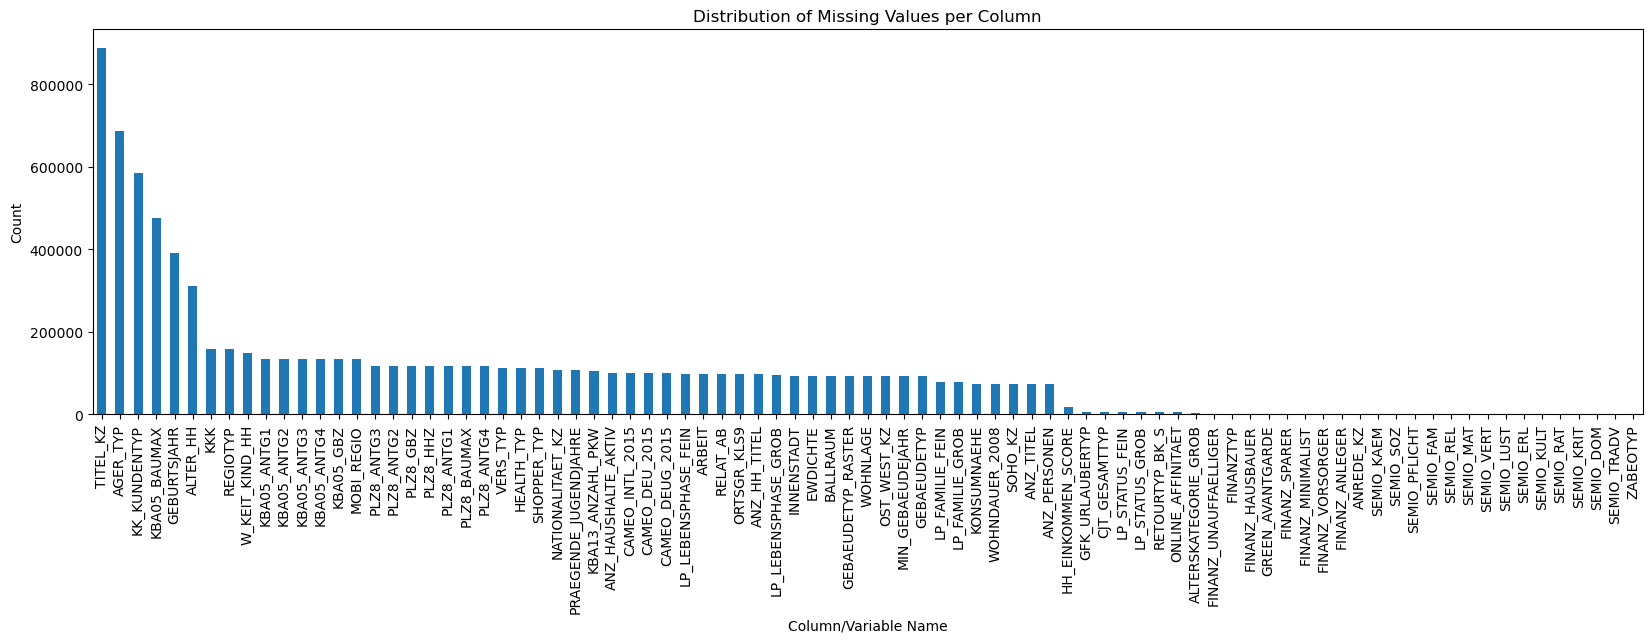

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.figure(figsize=(20,5))
missing = gen_pop.isna().sum().sort_values(ascending = False)
missing.plot(kind='bar')
plt.title('Distribution of Missing Values per Column')
plt.ylabel('Count')
plt.xlabel('Column/Variable Name')
plt.show()


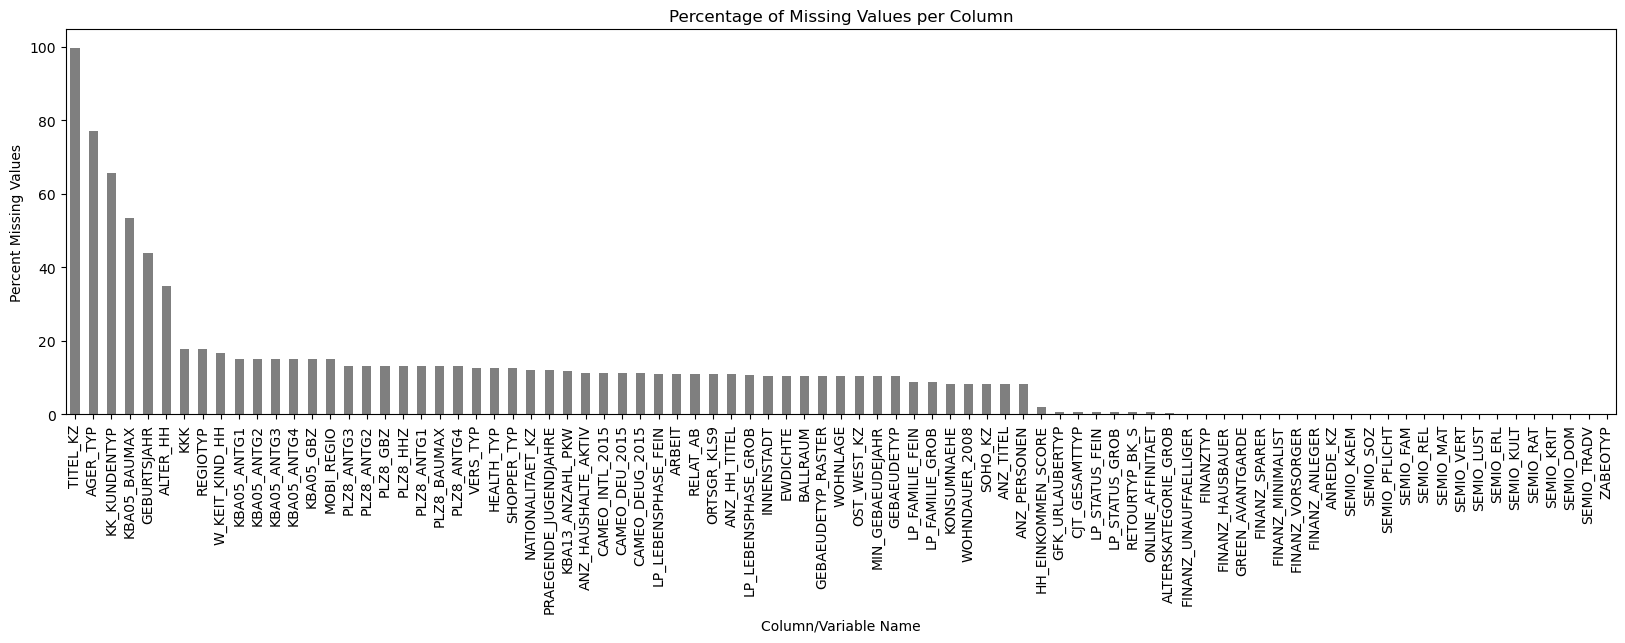

In [9]:
# Investigate patterns in the amount of missing data in each column
plt.figure(figsize=(20,5))
missing_percent = (gen_pop.isna().sum() / len(gen_pop) * 100)
missing_percent = missing_percent.sort_values(ascending=False)
missing_percent.plot(kind='bar', color='tab:gray')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percent Missing Values')
plt.xlabel('Column/Variable Name')
plt.show()

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
threshold = 20
drop_cols_p = []
for col in missing_percent.index:
    if missing_percent[col] > threshold:
        drop_cols_p.append(col)

print(f'The following columns have more than 20% missing values and will be dropped from data: {drop_cols_p}')
gen_pop.drop(columns=drop_cols_p, inplace=True)

The following columns have more than 20% missing values and will be dropped from data: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


#### Discussion 1.1.2: Assess Missing Data in Each Column

A small group of data were more than 20% NaN and were removed from the dataset. As for patterns in the missing data, it seems like there are patterns with the "parent" name of a family of variables. For example, all of the variables that begin with the four letters "PLZ8" have the same percentage of of missing values. This is likely due to sampling techniques.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

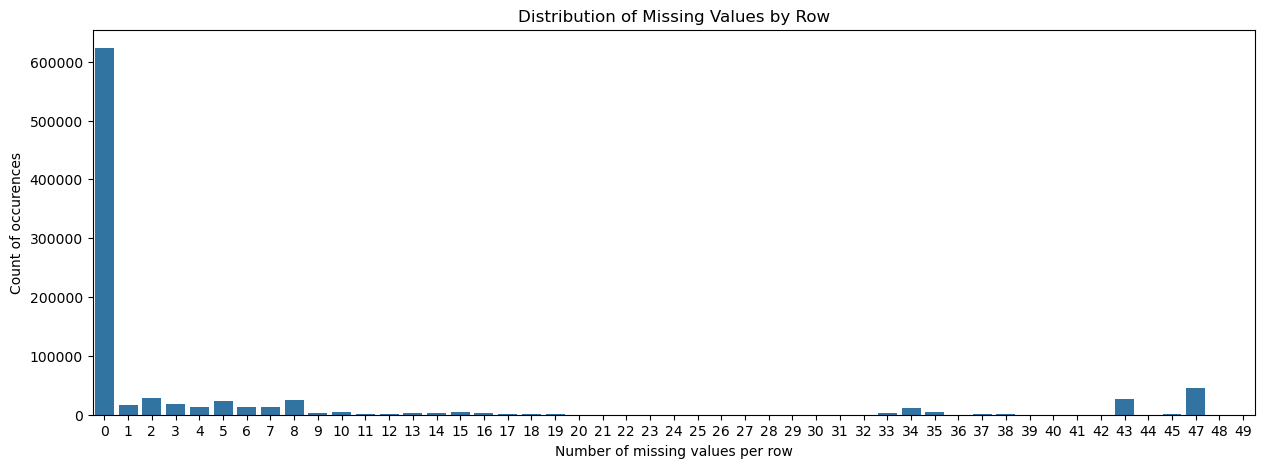

In [11]:
# How much data is missing in each row of the dataset?
missing_row = gen_pop.isna().sum(axis=1)
plt.figure(figsize=(15,5))
sns.countplot(x=missing_row)
#missing_row.hist(bins=max(missing_row), grid=False)
plt.title('Distribution of Missing Values by Row')
plt.xlabel('Number of missing values per row')
plt.ylabel('Count of occurences')
plt.show()

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
cutoff_threshold = 8
gen_pop['RowNaValues'] = missing_row
gen_pop['Group'] = None

gen_pop['Group'] = np.where(gen_pop['RowNaValues'] < cutoff_threshold, 1, 2)
gen_pop_few_missing = gen_pop[gen_pop['Group'] == 1]
gen_pop_many_missing = gen_pop[gen_pop['Group'] == 2]

In [13]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
zero_missing = list(missing[missing == 0].index)
random.shuffle(zero_missing)
comparison = zero_missing[:5]
print(f'5 column names with zero missing values are:\n{comparison}')

5 column names with zero missing values are:
['FINANZ_VORSORGER', 'ZABEOTYP', 'SEMIO_RAT', 'SEMIO_PFLICHT', 'SEMIO_KULT']


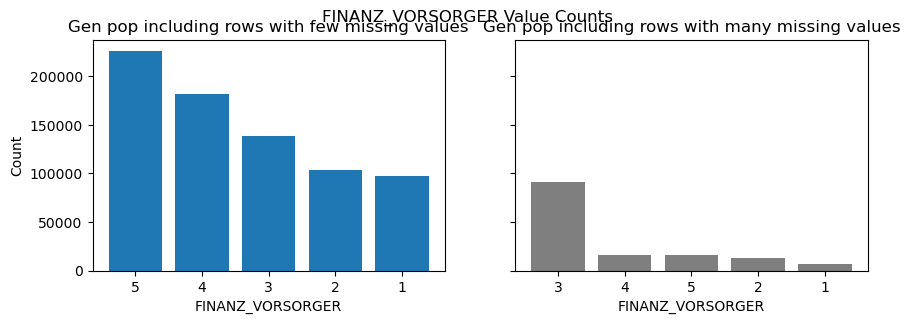

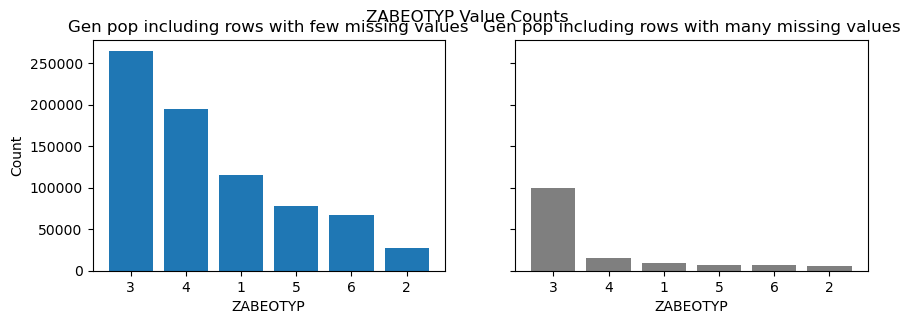

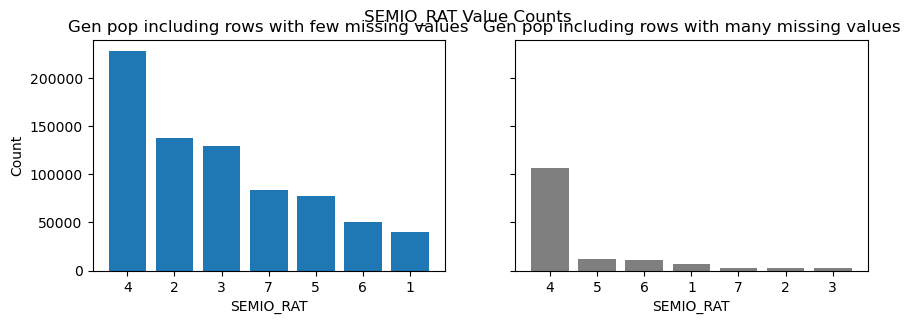

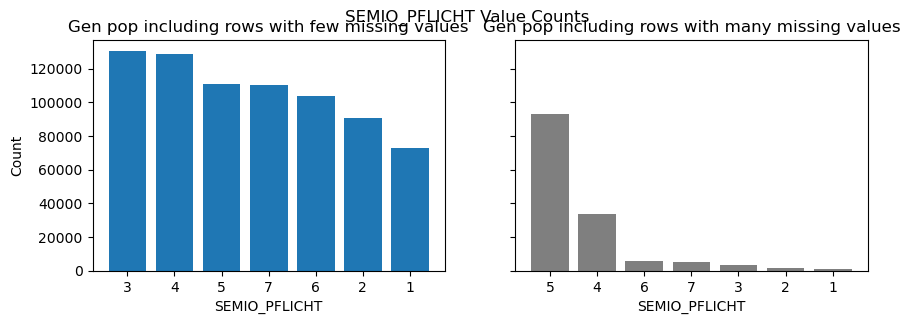

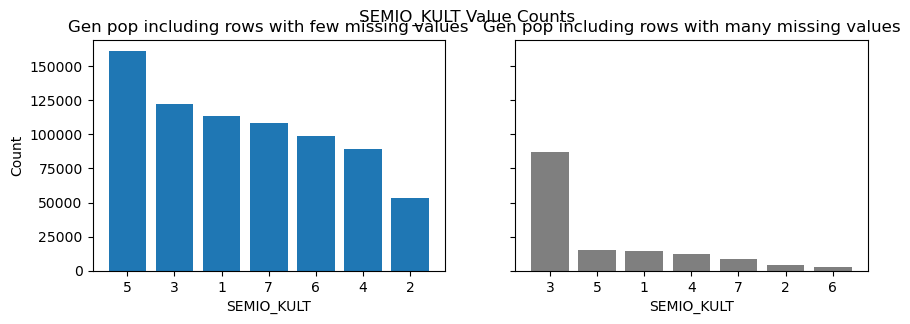

In [14]:
for col in comparison:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

    vc1 = gen_pop_few_missing[col].value_counts()
    vc2 = gen_pop_many_missing[col].value_counts()

    ax[0].bar(vc1.index.astype(str), vc1.values, color='tab:blue')
    ax[0].set_title(f'Gen pop including rows with few missing values')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Count')

    ax[1].bar(vc2.index.astype(str), vc2.values, color='tab:gray')
    ax[1].set_title(f'Gen pop including rows with many missing values')
    ax[1].set_xlabel(col)

    plt.suptitle(f"{col} Value Counts")
    plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

There is a highly skewed distribution of missing value counts for rows that centers around 3 and has extremeties at approximately 6. 7 missing values was chosen as a threshold for appropriate missing values, which reduced the total length of the DataFrame for both above and below that threshold. The dataframe for below that threshold (gen_pop_few_missing) contains the most amount of values at just under 700,000, while the other dataframe contains the rest. The graph above displays the quantity of non-missing values for a few select column names before and after splitting the data. Interpretations are going to be made with "gen_pop_few_missing", so the visualizations show that there is still ample data to work with. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [15]:
# How many features are there of each data type?
feat = list(gen_pop_few_missing.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(feat)]
count = feat_info_clean['type'].value_counts()  

In [16]:
for k,v in count.items():
    print(f'{k.capitalize()} feature type has {v} values.')

Ordinal feature type has 49 values.
Categorical feature type has 18 values.
Mixed feature type has 6 values.
Numeric feature type has 6 values.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categoricals = feat_info_clean[feat_info_clean['type'] == 'categorical']
categoricals = categoricals['attribute']
print(f'Categoricals:\n\n{categoricals}')


Categoricals:

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [18]:
# Binary Features
binary = []
for att in categoricals:
    args = len(gen_pop_few_missing[att].unique())
    if args == 2:
        binary.append(att)
for att in binary:
    print(f'The following attributes are binary: {att} with {gen_pop_few_missing[att].unique()} values.')

# Convert float values to int64
gen_pop_few_missing.loc[:, 'SOHO_KZ'] = gen_pop_few_missing['SOHO_KZ'].astype('int64')

The following attributes are binary: ANREDE_KZ with [2 1] values.
The following attributes are binary: GREEN_AVANTGARDE with [0 1] values.
The following attributes are binary: SOHO_KZ with [1. 0.] values.
The following attributes are binary: OST_WEST_KZ with ['W' 'O'] values.


In [19]:
# Multi-level features
mult = []
for att in categoricals:
    args = len(gen_pop_few_missing[att].unique())
    if args > 2:
        mult.append(att)
print(f'The following attributes are multi-level: {mult}\nThe multi-level values are:')
for att in mult:
    print(f'{gen_pop_few_missing[att].unique()}')

The following attributes are multi-level: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
The multi-level values are:
[5. 3. 2. 4. 1. 6.]
[1 6 5 2 4 3]
[10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6.]
[ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
[ 3.  1. nan  5.  2.  4.]
[ 2.  3.  9.  4.  1. 10.  8.  5.  6.  7.]
[1. 2. 4. 5. 3.]
[ 1.  3.  2. nan]
[ 3.  2.  1.  0. nan]
[ 2.  1. nan]
[5 3 4 1 6 2]
[8. 1. 3. 2. 6. 4. 5.]
['8' '4' '2' '6' '1' '9' '7' '5' '3' nan]
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Encode 'W' and 'O' in with 0 and 1
gen_pop_clean = gen_pop_few_missing.copy()
gen_pop_clean['OST_WEST_KZ'] = gen_pop_clean['OST_WEST_KZ'].replace({'W':0, 'O':1}).astype('int64')

C:\Users\ryker\AppData\Local\Temp\ipykernel_16268\1468851848.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gen_pop_clean['OST_WEST_KZ'] = gen_pop_clean['OST_WEST_KZ'].replace({'W':0, 'O':1}).astype('int64')


In [21]:
# Drop multi-level features
gen_pop_clean.drop(columns=mult, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

For this analysis, multi-level features were dropped for simplicity. String binary values were encoded. Binary values were converted to int64.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Create encode mappings
decade_encode = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_encode = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}

# Map encodings
gen_pop_clean['DECADE'] = gen_pop_clean['PRAEGENDE_JUGENDJAHRE'].map(decade_encode)
gen_pop_clean['MOVEMENT'] = gen_pop_clean['PRAEGENDE_JUGENDJAHRE'].map(movement_encode)

# Drop original column
gen_pop_clean.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

# https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html#pandas.Series.map

In [23]:
# Drop NA rows from CAMEO_INTL_2015 in order to convert to int64.
# This removes only about 1,000 values and it's much easier to work with.
gen_pop_clean = gen_pop_clean[gen_pop_clean['CAMEO_INTL_2015'].notna()].copy()

# Convert to int64 
gen_pop_clean.loc[:, 'CAMEO_INTL_2015'] = gen_pop_clean['CAMEO_INTL_2015'].astype('int64')

In [24]:
# Create encode mappings
wealth_encode = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
lifestage_encode = {11:1, 21:1, 31:1, 41:1, 51:1, 12:2, 22:2, 32:2, 42:2, 52:2, 13:3, 23:3, 33:3, 43:3, 53:3, 14:4, 24:4, 34:4, 44:4, 54:4, 15:5, 25:5, 35:5, 45:5, 55:5}

# Map encodings
gen_pop_clean['WEALTH'] = gen_pop_clean['CAMEO_INTL_2015'].map(wealth_encode)
gen_pop_clean['LIFESTAGE'] = gen_pop_clean['CAMEO_INTL_2015'].map(lifestage_encode)

# Drop original column
gen_pop_clean.drop(columns=['CAMEO_INTL_2015'], inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Using the map function decade, movement, wealth, and lifestage variables were incoded to numbers using a manual dictionary mapping system. The original columns were dropped for the now-encoded mixed-variables. The variable 'CAMEO_INTL_2015' gave difficulty because the value dtypes were not integers, and translating them to integers is not possible on NaN values. Therefore, the rows that were missing from 'CAMEO_INTL_2015' were removed completely before translating to integer dtype. This removed about 1,000 rows, which is not significant for the total amount of rows in this dataset. Other mixed-type variables will be removed later.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Verify types
feat_v2 = list(gen_pop_clean.columns)
feat_info_clean_v2 = feat_info[feat_info['attribute'].isin(feat_v2)]
count_v2 = feat_info_clean_v2['type'].value_counts() 
for k,v in count_v2.items():
    print(f'{k.capitalize()} feature type has {v} values.')


Ordinal feature type has 49 values.
Numeric feature type has 6 values.
Categorical feature type has 4 values.
Mixed feature type has 4 values.


In [26]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Create a list of Mixed variables for the original dataFrame
mix = feat_info_clean[feat_info_clean['type'] == 'mixed']['attribute']

# Determine what Mixed variables are in the current gen pop dataframe.
mixin = [x for x in mix if x in gen_pop_clean.columns]

gen_pop_clean.drop(columns=mixin, inplace=True)

# Drop column for calculations that are no longer necessary
gen_pop_clean.drop(columns=['RowNaValues', 'Group'], inplace=True)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [27]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    clean_df = df.copy()
    
    ### Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for _, row in feat_info.iterrows():
        att = row['attribute']
        missing = row['missing_or_unknown']
        clean_df[att] = clean_df[att].replace(missing, np.nan)
        if att not in clean_df.columns:
            print(f'{att} not in {clean_df.name} data!')
    
    # Drop NA rows from CAMEO_INTL_2015 in order to convert to int64
    clean_df = clean_df[clean_df['CAMEO_INTL_2015'].notna()]
    clean_df.loc[:,'CAMEO_INTL_2015'] = clean_df['CAMEO_INTL_2015'].astype('int64')
    clean_df.loc[:,'SOHO_KZ'] = clean_df['SOHO_KZ'].astype('int64')
    
    ### select, re-encode, and engineer column values.
    # handle binary categoricals that are non-numeric
    temp = clean_df['OST_WEST_KZ'].copy()
    temp.replace(['W', 'O'], [0, 1], inplace=True)
    clean_df['OST_WEST_KZ'] = temp

    # handle re-encoding and removal of mixed types
    decade_encode = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_encode = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}
    wealth_encode = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    lifestage_encode = {11:1, 21:1, 31:1, 41:1, 51:1, 12:2, 22:2, 32:2, 42:2, 52:2, 13:3, 23:3, 33:3, 43:3, 53:3, 14:4, 24:4, 34:4, 44:4, 54:4, 15:5, 25:5, 35:5, 45:5, 55:5}
    
    clean_df['DECADE'] = clean_df['PRAEGENDE_JUGENDJAHRE'].map(decade_encode)
    clean_df['MOVEMENT'] = clean_df['PRAEGENDE_JUGENDJAHRE'].map(movement_encode)
    clean_df['WEALTH'] = clean_df['CAMEO_INTL_2015'].map(wealth_encode)
    clean_df['LIFESTAGE'] = clean_df['CAMEO_INTL_2015'].map(lifestage_encode)

    clean_df.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    clean_df.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

    # Columns to drop
    drop_cols = []
    for col in clean_df.columns:
        if col not in gen_pop_clean.columns:
            drop_cols.append(col)
    
    clean_df.drop(columns=drop_cols, inplace=True)
    
    # Return the cleaned dataframe.
    return clean_df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [28]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp = SimpleImputer(strategy='most_frequent')
gen_pop_imp = pd.DataFrame(imp.fit_transform(gen_pop_clean))

# Convert columns
gen_pop_imp.columns = gen_pop_clean.columns

In [29]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
gen_pop_scaled = pd.DataFrame(scaler.fit_transform(gen_pop_imp))

# Convert columns
gen_pop_scaled.columns = gen_pop_clean.columns

### Discussion 2.1: Apply Feature Scaling

The simple imputer was used to eliminate NaN values with a strategy of "most_frequent" because it is the most likely option. A standard scaler was chosen for simplicity and due to the instructed suggestion.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the data.
pca1 = PCA(n_components=None)
pca1.fit_transform(gen_pop_scaled)

pca2 = PCA(n_components=5)
pca2.fit_transform(gen_pop_scaled)

pca3 = PCA(n_components=10)
pca3.fit_transform(gen_pop_scaled)

pca4 = PCA(n_components=15)
pca4.fit_transform(gen_pop_scaled)

pca5 = PCA(n_components=20)
pca5.fit_transform(gen_pop_scaled)


'\n# Apply PCA to the data.\npca1 = PCA(n_components=None)\npca1.fit_transform(clean_scaled)\n\npca2 = PCA(n_components=5)\npca2.fit_transform(clean_scaled)\n\npca3 = PCA(n_components=10)\npca3.fit_transform(clean_scaled)\n\npca4 = PCA(n_components=15)\npca4.fit_transform(clean_scaled)\n\npca5 = PCA(n_components=20)\npca5.fit_transform(clean_scaled)\n'

In [ ]:
# Investigate the variance accounted for by each principal component.
def plot_PC_line(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    cumvals = np.cumsum(vals)
    plt.plot(ind, cumvals)
    #for i in range(num_components):
    #   plt.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    #plt.xaxis.set_tick_params(width=0)
    #plt.yaxis.set_tick_params(width=2, length=12)

    plt.gca().set_ylim(0,1.05)
    plt.gca().set_xlim(-5,70)
    plt.gca().set_xlabel("Principal Component")
    plt.gca().set_ylabel("Variance-Explained Ratio")
    plt.title('Explained Variance Per Principal Component')
    plt.show()

plot_PC_line(pca1)


In [ ]:
plot_PC_line(pca2)

In [ ]:
plot_PC_line(pca3)

In [ ]:
plot_PC_line(pca4)

In [ ]:
plot_PC_line(pca5)

In [ ]:
############# Modified code from lesson-provided helper functions
# Dimension indexing
def plot_PC_comp(pca):
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = gen_pop_scaled.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    plt.show()

plot_PC_comp(pca1)


In [ ]:
plot_PC_comp(pca2)

In [ ]:
plot_PC_comp(pca3)

In [ ]:
plot_PC_comp(pca4)

In [ ]:
plot_PC_comp(pca5)

In [41]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
gen_pop_pca = pca.fit_transform(gen_pop_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

Based on the findings, approximately 30 PCA will explain about 85-90% of the variance, resulting in PCA of 30 being chosen for this clustering analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [42]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pcaw(pca, component_num):
    cn = component_num - 1 # Correct for proper indexing. component number 1 will be index number 0.
    df = pd.DataFrame(pca.components_)
    df.columns = gen_pop_scaled.columns
    weights = df.iloc[cn].sort_values(ascending=False) # Sort the weights for the component.
    return print(weights)

pcaw(pca, 1)


PLZ8_ANTG3               0.224084
PLZ8_ANTG4               0.217263
WEALTH                   0.205539
HH_EINKOMMEN_SCORE       0.202201
ORTSGR_KLS9              0.194315
EWDICHTE                 0.192036
FINANZ_HAUSBAUER         0.157760
KBA05_ANTG4              0.152516
PLZ8_ANTG2               0.151749
FINANZ_SPARER            0.150955
ARBEIT                   0.141815
KBA05_ANTG3              0.136074
ANZ_HAUSHALTE_AKTIV      0.135066
RELAT_AB                 0.133062
SEMIO_PFLICHT            0.119069
SEMIO_REL                0.116372
DECADE                   0.111303
SEMIO_RAT                0.099218
SEMIO_TRADV              0.096163
SEMIO_MAT                0.085588
SEMIO_FAM                0.082115
FINANZ_UNAUFFAELLIGER    0.080884
SEMIO_KULT               0.076868
FINANZ_ANLEGER           0.072208
REGIOTYP                 0.063730
OST_WEST_KZ              0.055312
SEMIO_SOZ                0.044462
KKK                      0.041212
PLZ8_HHZ                 0.040701
SEMIO_KAEM    

In [43]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pcaw(pca, 2))


ALTERSKATEGORIE_GROB     0.255745
SEMIO_ERL                0.229221
FINANZ_VORSORGER         0.228013
SEMIO_LUST               0.179028
RETOURTYP_BK_S           0.164799
FINANZ_HAUSBAUER         0.120236
SEMIO_KRIT               0.118620
W_KEIT_KIND_HH           0.114118
SEMIO_KAEM               0.114017
PLZ8_ANTG3               0.100226
EWDICHTE                 0.096998
PLZ8_ANTG4               0.096082
ORTSGR_KLS9              0.095943
ANREDE_KZ                0.091639
WEALTH                   0.079108
KBA05_ANTG4              0.074828
ARBEIT                   0.070844
SEMIO_DOM                0.069750
PLZ8_ANTG2               0.068319
RELAT_AB                 0.068249
ANZ_HAUSHALTE_AKTIV      0.065383
FINANZ_MINIMALIST        0.060408
HH_EINKOMMEN_SCORE       0.058305
WOHNDAUER_2008           0.057424
KBA05_ANTG3              0.049441
ANZ_HH_TITEL             0.031654
OST_WEST_KZ              0.028278
REGIOTYP                 0.016890
PLZ8_HHZ                 0.014243
ANZ_TITEL     

In [44]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pcaw(pca, 3))

SEMIO_VERT               0.347735
SEMIO_SOZ                0.263544
SEMIO_FAM                0.250279
SEMIO_KULT               0.232249
FINANZ_MINIMALIST        0.156336
RETOURTYP_BK_S           0.112731
FINANZ_VORSORGER         0.099940
W_KEIT_KIND_HH           0.088564
ALTERSKATEGORIE_GROB     0.080556
SEMIO_REL                0.072398
SEMIO_LUST               0.066697
SEMIO_MAT                0.053524
MOVEMENT                 0.048764
GREEN_AVANTGARDE         0.048764
ORTSGR_KLS9              0.048073
EWDICHTE                 0.047605
PLZ8_ANTG4               0.046655
PLZ8_ANTG3               0.046332
ARBEIT                   0.034251
WOHNDAUER_2008           0.033193
RELAT_AB                 0.032064
PLZ8_ANTG2               0.031115
KBA05_ANTG4              0.028404
WEALTH                   0.027026
ANZ_HAUSHALTE_AKTIV      0.025531
OST_WEST_KZ              0.014323
ANZ_HH_TITEL             0.013486
ANZ_TITEL                0.009419
KBA05_ANTG3              0.009102
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

It is possible to interpret the relationship between variables in the PCA, but it may prove quite challenging as the values are of a lot magnitude, and many are close in value to each other. It Especially when printed from largest to smallest value, it is apparent that many variables are highly correlated with each other. It may not be practical to interpret positive or negative relationship based on this data alone given its complexity.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
########## Modified from a lessson-provided function
counts = list(range(1,31))

def get_kmeans_score(df, cluster_counts):
    #instantiate kmeans
    kmeans = KMeans(n_clusters=cluster_counts, n_init='auto')

    # Then fit the model to your data using the fit method
    model = kmeans.fit(df)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(df))
    
    return score

scores = []

for c in counts:
    scores.append(get_kmeans_score(gen_pop_pca, c))

"\ncounts = list(range(1,31))\n\ndef get_kmeans_score(df, cluster_counts):\n    #instantiate kmeans\n    kmeans = KMeans(n_clusters=cluster_counts, n_init='auto')\n\n    # Then fit the model to your data using the fit method\n    model = kmeans.fit(df)\n    \n    # Obtain a score related to the model fit\n    score = np.abs(model.score(df))\n    \n    return score\n\nscores = []\n\nfor c in counts:\n    scores.append(get_kmeans_score(gen_pop_pca, c))\n"

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(counts, scores, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('Sum Squared Error')
plt.title('Sum Squared Error vs. K')
plt.show()

In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=12, n_init='auto')
model = kmeans.fit(gen_pop_pca)
gen_pop_pred = model.predict(gen_pop_pca)


### Discussion 3.1: Apply Clustering to General Population

While there is not one clear "elbow" when mapping different clusters, it appears to trend upward after the 12th point before falling back downward again. Due to this, 12 clusters were chosen. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [48]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [49]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cust_clean = clean_data(customers)

cust_clean_imp = pd.DataFrame(imp.fit_transform(cust_clean))

# Convert columns
cust_clean_imp.columns = cust_clean.columns

# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
cust_scaled = pd.DataFrame(scaler.fit_transform(cust_clean_imp))

# Convert columns
cust_scaled.columns = gen_pop_clean.columns

C:\Users\ryker\AppData\Local\Temp\ipykernel_16268\4083789886.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp.replace(['W', 'O'], [0, 1], inplace=True)


In [51]:
cust_pca = pca.transform(cust_scaled)

cust_pred = model.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

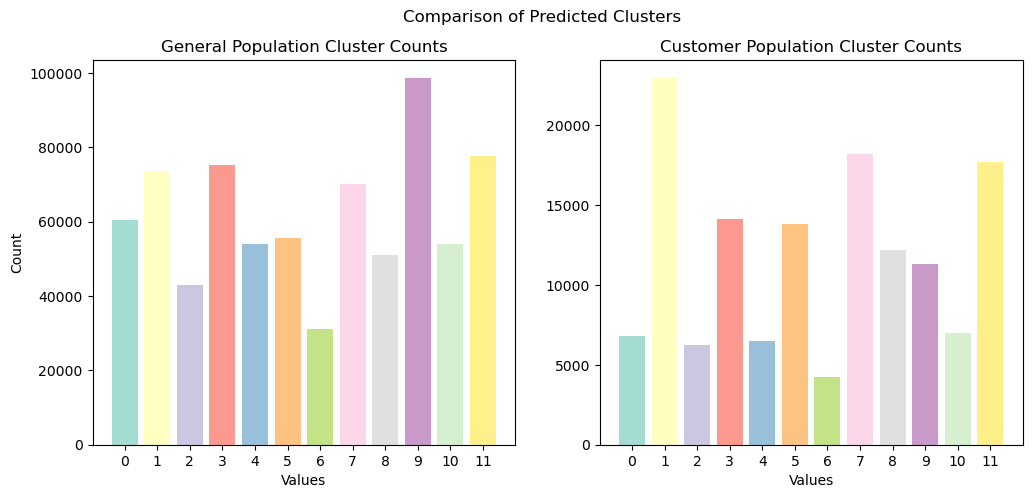

In [52]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

unique1, counts1 = np.unique(gen_pop_pred, return_counts=True)
unique2, counts2 = np.unique(cust_pred, return_counts=True)

# Generate distinct colors
colors = plt.get_cmap('Set3', len(counts1)).colors

# Create bar plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot
axes[0].bar(unique1.astype(str), counts1, color=colors, alpha=0.8)
axes[0].set_title('General Population Cluster Counts')
axes[0].set_xlabel("Values")
axes[0].set_ylabel("Count")

# Second plot
axes[1].bar(unique2.astype(str), counts2, color=colors, alpha=0.8)
axes[1].set_title('Customer Population Cluster Counts')
axes[1].set_xlabel("Values")

plt.suptitle("Comparison of Predicted Clusters")
plt.show()


In [53]:
# Gen Pop cluster proportions
percent1=[]
i=0
for c in counts1:
    i+=1
    percent1.append(c / sum(counts1) * 100)
    print(f'The {i} cluster represents ~{round(c / sum(counts1) * 100,2)}% of the Gen Pop Data.')



The 1 cluster represents ~8.12% of the Gen Pop Data.
The 2 cluster represents ~9.91% of the Gen Pop Data.
The 3 cluster represents ~5.76% of the Gen Pop Data.
The 4 cluster represents ~10.11% of the Gen Pop Data.
The 5 cluster represents ~7.25% of the Gen Pop Data.
The 6 cluster represents ~7.46% of the Gen Pop Data.
The 7 cluster represents ~4.18% of the Gen Pop Data.
The 8 cluster represents ~9.42% of the Gen Pop Data.
The 9 cluster represents ~6.86% of the Gen Pop Data.
The 10 cluster represents ~13.25% of the Gen Pop Data.
The 11 cluster represents ~7.25% of the Gen Pop Data.
The 12 cluster represents ~10.43% of the Gen Pop Data.


In [54]:
# Customer cluster proportions
percent2=[]
i=0
for c in counts2:
    i+=1
    percent2.append(c / sum(counts2) * 100)
    print(f'The {i} cluster represents ~{round(c / sum(counts2) * 100,2)}% of the Customer Data.')

The 1 cluster represents ~4.83% of the Customer Data.
The 2 cluster represents ~16.27% of the Customer Data.
The 3 cluster represents ~4.44% of the Customer Data.
The 4 cluster represents ~10.0% of the Customer Data.
The 5 cluster represents ~4.62% of the Customer Data.
The 6 cluster represents ~9.8% of the Customer Data.
The 7 cluster represents ~3.02% of the Customer Data.
The 8 cluster represents ~12.89% of the Customer Data.
The 9 cluster represents ~8.63% of the Customer Data.
The 10 cluster represents ~8.02% of the Customer Data.
The 11 cluster represents ~4.94% of the Customer Data.
The 12 cluster represents ~12.56% of the Customer Data.


In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Calculate the larges positive difference between customer data and general population data.
cust_diff = []
for i in range(len(percent1)):
    cust_diff.append(percent2[i] - percent1[i])
print(cust_diff)
maxover = cust_diff.index(max(cust_diff))
print(max(cust_diff))

# Back-project information to get originial features
pca_overrep = pca.inverse_transform(model.cluster_centers_[maxover])
pca_overrep = pca_overrep.reshape(1, -1)
cluster = scaler.inverse_transform(pca_overrep)
person = pd.DataFrame(cluster, columns=cust_clean.columns)
person = person.iloc[0]
print(person)

[-3.290453132355813, 6.362052992188197, -1.3197241358481433, -0.11141315969771526, -2.6301281153102636, 2.3444634653659486, -1.159989893920622, 3.472988358323864, 1.7628683832763485, -5.236565531749063, -2.3164802141301406, 2.122380983857397]
6.362052992188197
ALTERSKATEGORIE_GROB        3.351171
ANREDE_KZ                   0.846379
FINANZ_MINIMALIST           4.844167
FINANZ_SPARER               1.654874
FINANZ_VORSORGER            4.267690
FINANZ_ANLEGER              1.871852
FINANZ_UNAUFFAELLIGER       2.090199
FINANZ_HAUSBAUER            1.786882
GREEN_AVANTGARDE            0.339320
HEALTH_TYP                  1.927778
RETOURTYP_BK_S              3.781180
SEMIO_SOZ                   5.270639
SEMIO_FAM                   5.432397
SEMIO_REL                   4.398722
SEMIO_MAT                   4.508363
SEMIO_VERT                  6.862269
SEMIO_LUST                  4.999148
SEMIO_ERL                   3.384551
SEMIO_KULT                  5.612404
SEMIO_RAT                   2.885199

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Calculate the largest negative difference between customers and the general population.
cust_diff = []
for i in range(len(percent1)):
    cust_diff.append(percent2[i] - percent1[i])
print(cust_diff)
minover = cust_diff.index(min(cust_diff))
print(min(cust_diff))

# Back-project information to get originial features
pca_overrep = pca.inverse_transform(model.cluster_centers_[minover])
pca_overrep = pca_overrep.reshape(1, -1)
cluster = scaler.inverse_transform(pca_overrep)
person = pd.DataFrame(cluster, columns=cust_clean.columns)
person = person.iloc[0]
print(person)

[-3.290453132355813, 6.362052992188197, -1.3197241358481433, -0.11141315969771526, -2.6301281153102636, 2.3444634653659486, -1.159989893920622, 3.472988358323864, 1.7628683832763485, -5.236565531749063, -2.3164802141301406, 2.122380983857397]
-5.236565531749063
ALTERSKATEGORIE_GROB        3.731947
ANREDE_KZ                   1.408322
FINANZ_MINIMALIST           5.173399
FINANZ_SPARER               1.226708
FINANZ_VORSORGER            4.701766
FINANZ_ANLEGER              1.669940
FINANZ_UNAUFFAELLIGER       1.910153
FINANZ_HAUSBAUER            1.663507
GREEN_AVANTGARDE            0.731154
HEALTH_TYP                  1.828998
RETOURTYP_BK_S              3.599604
SEMIO_SOZ                   4.100614
SEMIO_FAM                   3.225424
SEMIO_REL                   2.744416
SEMIO_MAT                   3.136352
SEMIO_VERT                  5.100945
SEMIO_LUST                  5.776265
SEMIO_ERL                   5.245798
SEMIO_KULT                  3.401496
SEMIO_RAT                   2.76092

### Discussion 3.3: Compare Customer Data to Demographics Data

For a person who is overrepresented in the customer data but underrepresented in the general demographic data, they are likely to be of the 50s decade, from the mainstream movement, from a prosperous household, and be family with school-age children. This individual is likely to be 46-60 years old and be of health typology "Sanitary Afine". As for a person who is underrepresented, they are likely to be older, i.e. from the 40s decade and closer to the avantguard movement. They are mote likely to be from a wealthy household and be an older family/mature couples. This individual is more likely to be >60 years old. 

It seems like the target demographic for this company should be people who are relatively well-doing, middle-aged families. The demographic that appears least likely to participate in mail-order items is mature/older and wealthy families. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.